In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import pairwise_distances
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster, leaves_list
import seaborn as sns
import matplotlib.pyplot as plt

mushroom_data = pd.read_csv("mushrooms.csv")

# stratify 3000 samples
stratified_sample = mushroom_data.groupby('class', group_keys=False).apply(
    lambda x: x.sample(min(len(x), 3000 // mushroom_data['class'].nunique()), random_state=42)
).reset_index(drop=True)

# encode
categorical_columns = stratified_sample.select_dtypes(include=['object']).columns
encoded_data = stratified_sample.copy()

label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    encoded_data[col] = le.fit_transform(encoded_data[col].astype(str))
    label_encoders[col] = le

X = encoded_data.drop(columns=['class'])  # Features
y = encoded_data['class']  # Target (edible or poisonous)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)





/var/folders/k8/kp1njk3j6ms3bxl4lxwr6xth0000gn/T/ipykernel_30920/1369528494.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  stratified_sample = mushroom_data.groupby('class', group_keys=False).apply(


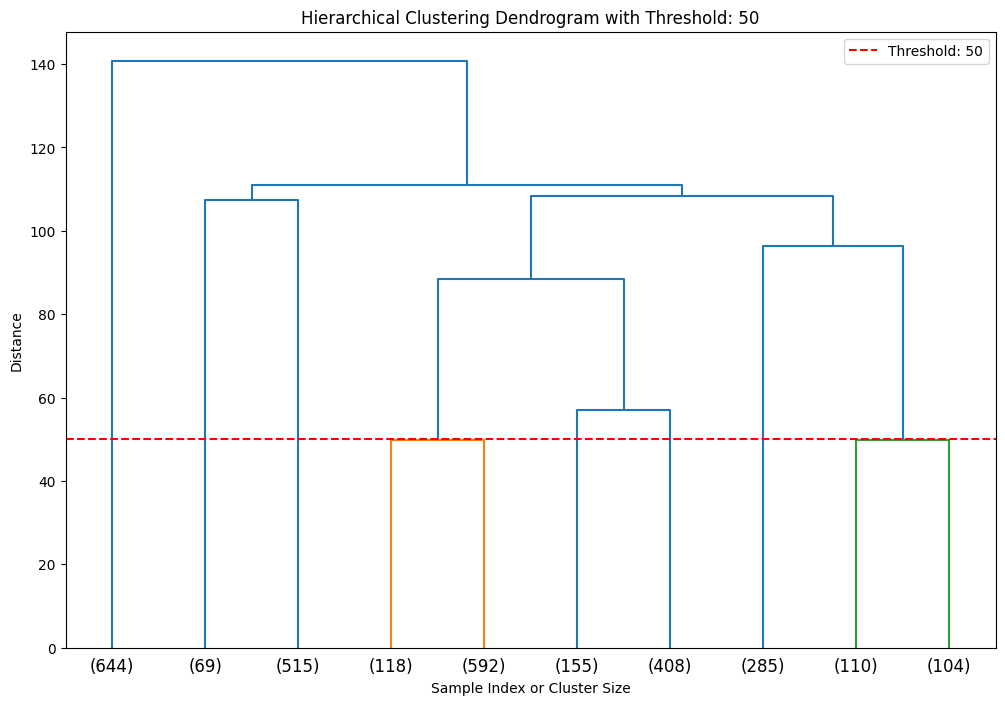

In [2]:
# hierarchical clustering
linkage_matrix = linkage(X_scaled, method='ward')

# dendrogram
plt.figure(figsize=(12, 8))
dendrogram(linkage_matrix, truncate_mode='lastp', p=10, color_threshold=50)
plt.axhline(y=50, color='r', linestyle='--', label='Threshold: 50')
plt.title('Hierarchical Clustering Dendrogram with Threshold: 50')
plt.xlabel('Sample Index or Cluster Size')
plt.ylabel('Distance')
plt.legend()
plt.show()

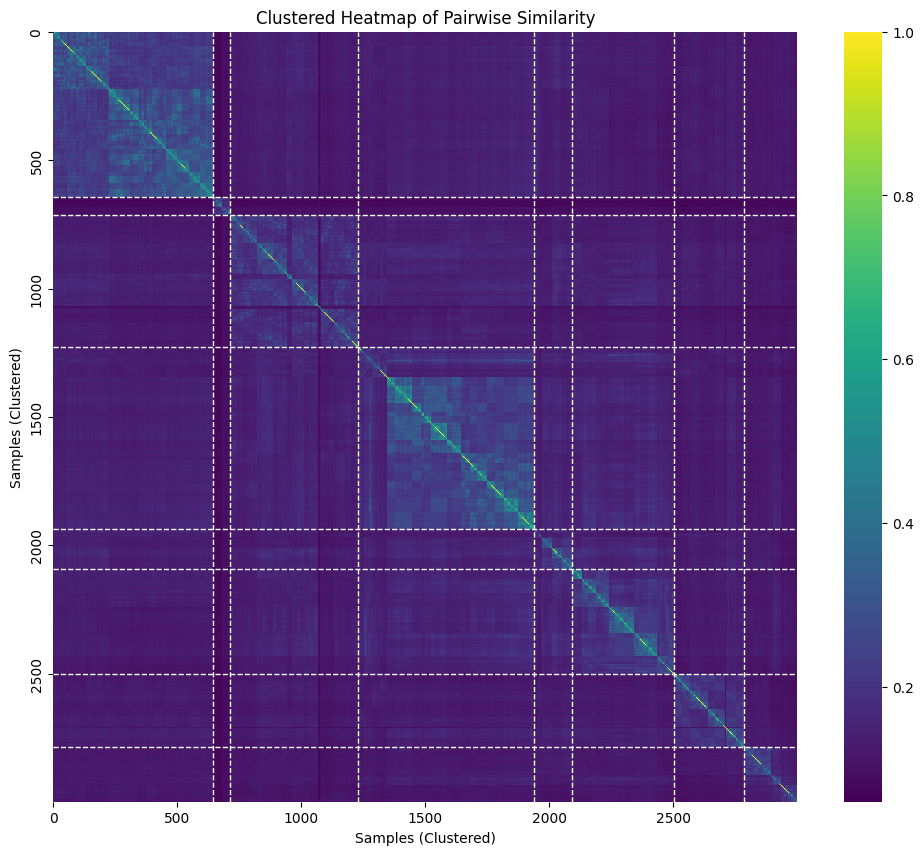

'\nThe heatmap of pairwise similarity visualizes the relationships between samples based on their hierarchical clustering structure.\nAlong the diagonal, bright square blocks represent clusters of samples with high internal similarity, indicating that these samples share common features.\nThe size of these blocks corresponds to the size of each cluster.\nThe dashed white lines mark the boundaries between clusters.\nSome brighter off diagonal areas indicate overlap or similarity between clusters, potentially reflecting shared characteristics.\n'

In [3]:
# pairwise similarity matrix
pairwise_similarity_matrix = 1 / (1 + pairwise_distances(X_scaled, metric='euclidean'))

threshold = 50  # Adjust threshold as needed
cluster_labels = fcluster(linkage_matrix, t=threshold, criterion='distance')

cluster_order = leaves_list(linkage_matrix)
reordered_matrix = pairwise_similarity_matrix[cluster_order][:, cluster_order]

cluster_boundaries = []
current_cluster = cluster_labels[cluster_order[0]]
for i, idx in enumerate(cluster_order):
    if cluster_labels[idx] != current_cluster:
        cluster_boundaries.append(i)
        current_cluster = cluster_labels[idx]

# heatmap with boundaries
plt.figure(figsize=(12, 10))

# lines for cluster boundaries
for boundary in cluster_boundaries:
    plt.axhline(y=boundary, color='white', linestyle='--', linewidth=1)
    plt.axvline(x=boundary, color='white', linestyle='--', linewidth=1)

plt.title("Clustered Heatmap of Pairwise Similarity")
sns.heatmap(reordered_matrix, cmap='viridis', xticklabels=500, yticklabels=500)

plt.xlabel("Samples (Clustered)")
plt.ylabel("Samples (Clustered)")
plt.show()

"""
The heatmap of pairwise similarity visualizes the relationships between samples based on their hierarchical clustering structure.
Along the diagonal, bright square blocks represent clusters of samples with high internal similarity, indicating that these samples share common features.
The size of these blocks corresponds to the size of each cluster.
The dashed white lines mark the boundaries between clusters.
Some brighter off diagonal areas indicate overlap or similarity between clusters, potentially reflecting shared characteristics.
"""



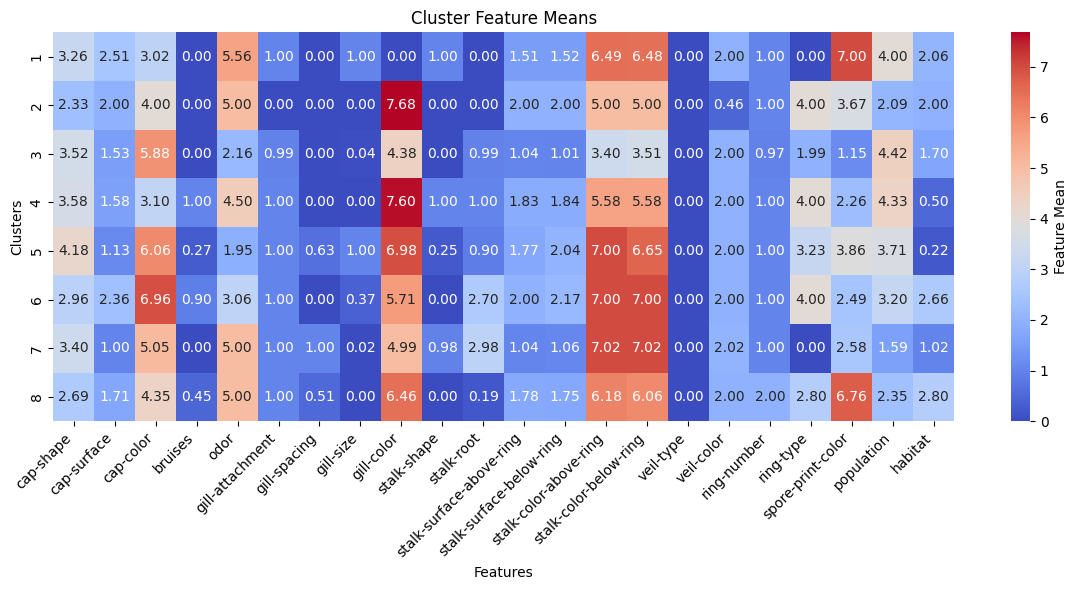

         cap-shape  cap-surface  cap-color   bruises      odor  \
Cluster                                                          
1         3.257764     2.509317   3.024845  0.000000  5.562112   
2         2.333333     2.000000   4.000000  0.000000  5.000000   
3         3.520388     1.532039   5.881553  0.000000  2.161165   
4         3.576056     1.578873   3.098592  1.000000  4.501408   
5         4.180645     1.129032   6.058065  0.270968  1.948387   
6         2.955882     2.357843   6.958333  0.901961  3.056373   
7         3.396491     1.000000   5.049123  0.000000  5.000000   
8         2.686916     1.714953   4.345794  0.453271  5.000000   

         gill-attachment  gill-spacing  gill-size  gill-color  stalk-shape  \
Cluster                                                                      
1               1.000000      0.000000   1.000000    0.000000     1.000000   
2               0.000000      0.000000   0.000000    7.681159     0.000000   
3               0.986408   

'\nVisualizes the mean feature values for each cluster - how features contribute to cluster definitions. \nheatmap shoes patterns and differences between clusters. \nfeatures like `stem-width` and `stem-height` have  variation across clusters, with Cluster 10 showing the highest mean values for `stem-width`, \nindicating its potential role as a defining feature for this cluster. Conversely, features like `veil-type` and `cap-surface` remain relatively consistent across clusters, \nsuggesting they play a less critical role in cluster differentiation. allow for the identification of features that uniquely characterize \neach cluster. \n'

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

encoded_data['Cluster'] = cluster_labels

# calculate the mean for each feature
cluster_feature_means = encoded_data.groupby('Cluster').mean()

if 'class' in cluster_feature_means.columns:
    cluster_feature_means = cluster_feature_means.drop(columns=['class'])

# heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(cluster_feature_means, annot=True, fmt=".2f", cmap="coolwarm", cbar_kws={'label': 'Feature Mean'})
plt.title("Cluster Feature Means")
plt.xlabel("Features")
plt.ylabel("Clusters")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()
print(cluster_feature_means)

"""
Visualizes the mean feature values for each cluster - how features contribute to cluster definitions. 
heatmap shoes patterns and differences between clusters. 
features like `stem-width` and `stem-height` have  variation across clusters, with Cluster 10 showing the highest mean values for `stem-width`, 
indicating its potential role as a defining feature for this cluster. Conversely, features like `veil-type` and `cap-surface` remain relatively consistent across clusters, 
suggesting they play a less critical role in cluster differentiation. allow for the identification of features that uniquely characterize 
each cluster. 
"""


Feature Correlation Matrix:
                             class  cap-shape  cap-surface  cap-color  \
class                     1.000000   0.044518     0.183878  -0.051545   
cap-shape                 0.044518   1.000000    -0.071867  -0.063546   
cap-surface               0.183878  -0.071867     1.000000  -0.020112   
cap-color                -0.051545  -0.063546    -0.020112   1.000000   
bruises                  -0.478595  -0.019271     0.087636   0.010694   
odor                     -0.099958  -0.043680     0.057646  -0.372688   
gill-attachment           0.131521   0.091204    -0.035945   0.043960   
gill-spacing             -0.353502   0.005201    -0.285811   0.150827   
gill-size                 0.532764   0.033649     0.218861  -0.162511   
gill-color               -0.509940   0.018025    -0.171045   0.075310   
stalk-shape              -0.100001   0.062192     0.002205  -0.453325   
stalk-root               -0.373785   0.024856    -0.123134   0.314592   
stalk-surface-above-ri

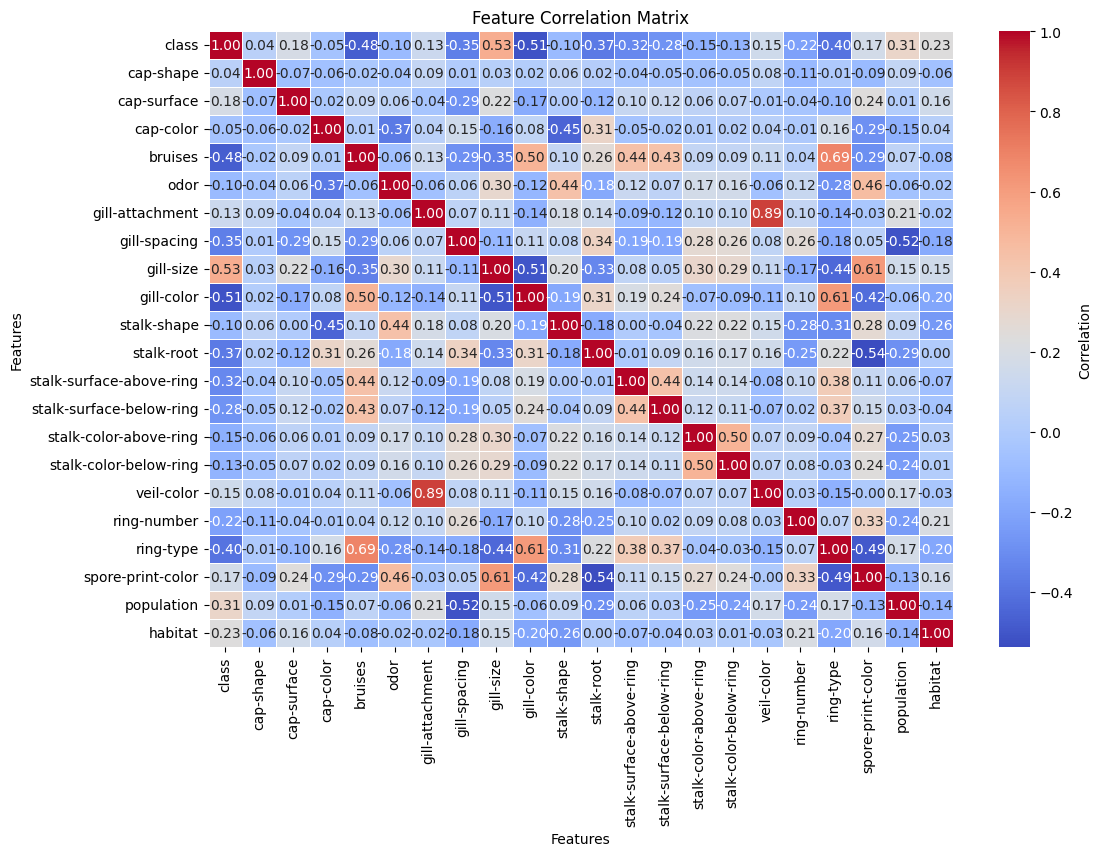

'\nThe correlation matrix quantifies the pairwise linear relationships between features, with values ranging from -1 (strong negative correlation) \nto +1 (strong positive correlation). The heatmap highlights these correlations, with the color intensity indicating the strength and direction \nof the relationships. For example, `stem-width` and `cap-diameter` show a strong positive correlation (0.659), suggesting that as the cap diameter \nincreases, the stem width also tends to increase. Conversely, features like `cap-diameter` and `class` have a weak negative correlation (-0.179), \nindicating a minor inverse relationship between cap size and toxicity. Features like `veil-type` and `veil-color` exhibit moderate positive correlations \nwith other variables, suggesting their potential importance in feature interactions. This analysis aids in understanding feature dependencies and \nidentifying redundancies, which can guide feature selection and improve clustering or predictive models. T

In [5]:
correlation_matrix = encoded_data.drop(columns=['Cluster', 'veil-type']).corr()
print("\nFeature Correlation Matrix:")
print(correlation_matrix)
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, cbar_kws={'label': 'Correlation'})
plt.title("Feature Correlation Matrix")
plt.xlabel("Features")
plt.ylabel("Features")
plt.show()
"""
The correlation matrix quantifies the pairwise linear relationships between features, with values ranging from -1 (strong negative correlation) 
to +1 (strong positive correlation). The heatmap highlights these correlations, with the color intensity indicating the strength and direction 
of the relationships. For example, `stem-width` and `cap-diameter` show a strong positive correlation (0.659), suggesting that as the cap diameter 
increases, the stem width also tends to increase. Conversely, features like `cap-diameter` and `class` have a weak negative correlation (-0.179), 
indicating a minor inverse relationship between cap size and toxicity. Features like `veil-type` and `veil-color` exhibit moderate positive correlations 
with other variables, suggesting their potential importance in feature interactions. This analysis aids in understanding feature dependencies and 
identifying redundancies, which can guide feature selection and improve clustering or predictive models. The correlation with `class` also provides 
insight into how specific features may contribute to toxicity classification.
"""


Class Percentage Distribution by Cluster:
class             0           1
Cluster                        
1          0.000000  100.000000
2        100.000000    0.000000
3          3.689320   96.310680
4         83.380282   16.619718
5         34.193548   65.806452
6         73.284314   26.715686
7         98.245614    1.754386
8         87.850467   12.149533


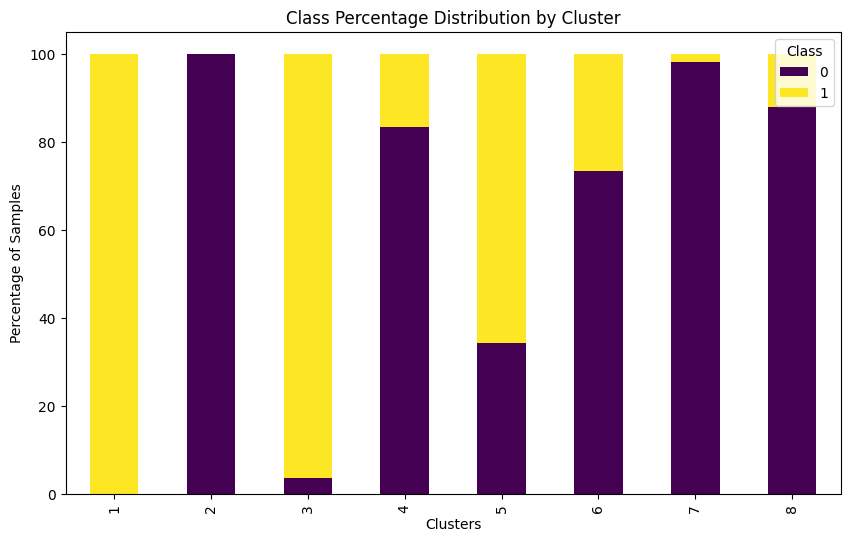

In [6]:
encoded_data['class'] = y  
encoded_data['Cluster'] = cluster_labels

# class distribution
class_distribution_percentage = (
    encoded_data.groupby('Cluster')['class']
    .value_counts(normalize=True)
    .unstack(fill_value=0) * 100
)

print("Class Percentage Distribution by Cluster:")
print(class_distribution_percentage)
class_distribution_percentage.plot(kind='bar', stacked=True, figsize=(10, 6), colormap="viridis")
plt.title("Class Percentage Distribution by Cluster")
plt.xlabel("Clusters")
plt.ylabel("Percentage of Samples")
plt.legend(title="Class", loc='upper right')
plt.show()


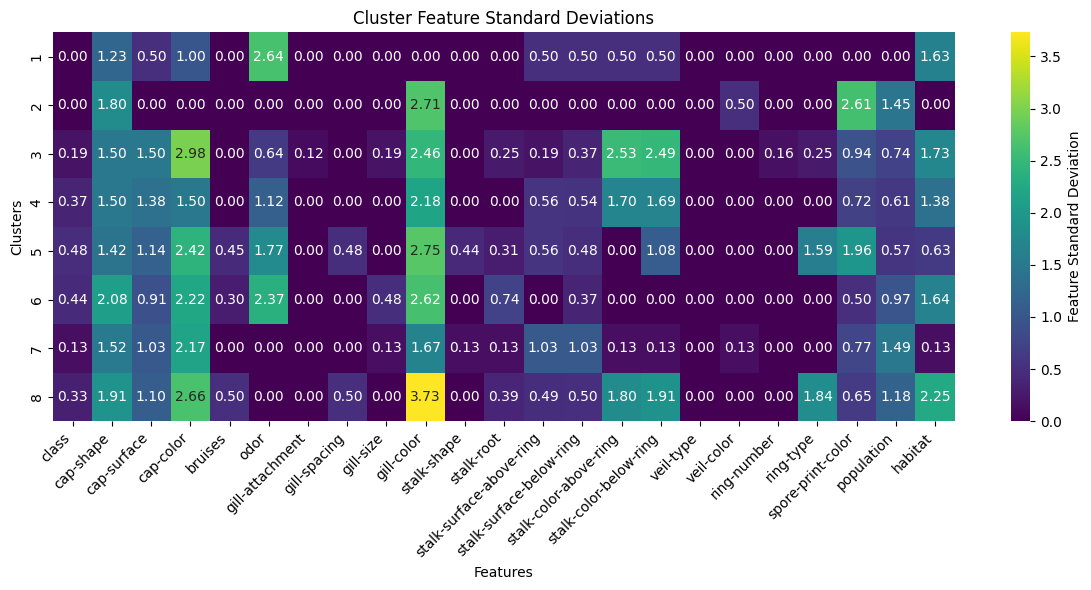

            class  cap-shape  cap-surface  cap-color   bruises      odor  \
Cluster                                                                    
1        0.000000   1.234050     0.500302   1.000468  0.000000  2.643256   
2        0.000000   1.795965     0.000000   0.000000  0.000000  0.000000   
3        0.188683   1.497427     1.501116   2.980408  0.000000  0.638614   
4        0.372520   1.499127     1.383503   1.498047  0.000000  1.117560   
5        0.475896   1.416374     1.137950   2.418110  0.445900  1.768386   
6        0.443018   2.081394     0.905559   2.218025  0.297733  2.372914   
7        0.131517   1.524676     1.027783   2.169988  0.000000  0.000000   
8        0.327468   1.911202     1.099748   2.664680  0.498979  0.000000   

         gill-attachment  gill-spacing  gill-size  gill-color  ...  \
Cluster                                                        ...   
1               0.000000      0.000000   0.000000    0.000000  ...   
2               0.000000     

'\nStandard deviation of each feature for all clusters, indicates the variability of each feature within a cluster, \nFeatures with low standard deviation, such as `veil-type` (0.0 across all clusters), \nsuggest that the feature remains consistent within clusters, \nmaking it less useful for differentiating between them. \nConversely, features like `stem-height` and `stem-width` exhibit high standard deviation in clusters such as Cluster 10, \nindicating significant diversity among samples in these clusters for those features. \ncompareing to the mean analysis, \nthis result highlights the features that not only define a cluster on average but also those that exhibit high variability and could indicate intra-cluster diversity. \nFor example, while `stem-width` has a high mean in Cluster 10, its high standard deviation suggests diverse stem widths among samples in that cluster. \nThese insights contribute to understanding the distinctiveness of clusters and can also aid in evaluating t

In [7]:
cluster_stds = encoded_data.groupby('Cluster').std()

plt.figure(figsize=(12, 6))
sns.heatmap(cluster_stds, annot=True, fmt=".2f", cmap="viridis", cbar_kws={'label': 'Feature Standard Deviation'})
plt.title("Cluster Feature Standard Deviations")
plt.xlabel("Features")
plt.ylabel("Clusters")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()
print(cluster_stds)
"""
Standard deviation of each feature for all clusters, indicates the variability of each feature within a cluster, 
Features with low standard deviation, such as `veil-type` (0.0 across all clusters), 
suggest that the feature remains consistent within clusters, 
making it less useful for differentiating between them. 
Conversely, features like `stem-height` and `stem-width` exhibit high standard deviation in clusters such as Cluster 10, 
indicating significant diversity among samples in these clusters for those features. 
compareing to the mean analysis, 
this result highlights the features that not only define a cluster on average but also those that exhibit high variability and could indicate intra-cluster diversity. 
For example, while `stem-width` has a high mean in Cluster 10, its high standard deviation suggests diverse stem widths among samples in that cluster. 
These insights contribute to understanding the distinctiveness of clusters and can also aid in evaluating the reliability of features for tasks such as toxicity prediction, 
where consistent features are often preferred.
"""


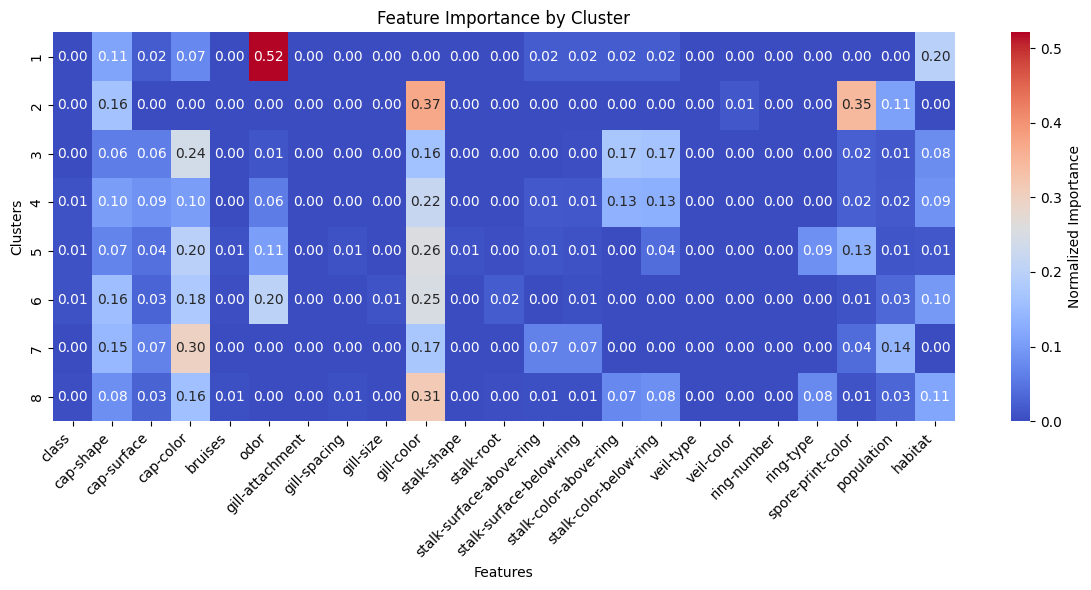

            class  cap-shape  cap-surface  cap-color   bruises      odor  \
Cluster                                                                    
1        0.000000   0.113584     0.018669   0.074655  0.000000  0.521110   
2        0.000000   0.163402     0.000000   0.000000  0.000000  0.000000   
3        0.000956   0.060203     0.060500   0.238495  0.000000  0.010950   
4        0.006396   0.103578     0.088216   0.103429  0.000000  0.057561   
5        0.007663   0.067877     0.043814   0.197843  0.006727  0.105809   
6        0.007094   0.156579     0.029639   0.177810  0.003204  0.203511   
7        0.001086   0.145999     0.066343   0.295740  0.000000  0.000000   
8        0.002422   0.082500     0.027317   0.160372  0.005623  0.000000   

         gill-attachment  gill-spacing  gill-size  gill-color  ...  \
Cluster                                                        ...   
1               0.000000      0.000000   0.000000    0.000000  ...   
2               0.000000     

'\nBy first computing the variance of each feature within clusters and then normalizing these values to sum to 1 per cluster, \nthe analysis highlights the relative contribution of each feature to the diversity within a cluster. \nfeatures with higher relative variance, which are likely to play a key role in defining the internal variability of clusters.\n\nWhen compared to the previously analyzed means and standard deviations, this analysis complements the insights by focusing on the \n**relative importance of features**, rather than their absolute values. For example, features like `cap-diameter` show consistently \nhigher normalized variance in multiple clusters, indicating that variability in `cap-diameter` significantly contributes to cluster \ndifferentiation. In contrast, features like `veil-type` consistently exhibit no variance, suggesting they are not informative for \ndistinguishing clusters.\n\nThe results contribute to understanding which features drive diversity within cl

In [8]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

feature_importance = encoded_data.groupby('Cluster').var()

normalized_importance = feature_importance.div(feature_importance.sum(axis=1), axis=0)

plt.figure(figsize=(12, 6))
sns.heatmap(normalized_importance, annot=True, fmt=".2f", cmap="coolwarm", cbar_kws={'label': 'Normalized Importance'})
plt.title("Feature Importance by Cluster")
plt.xlabel("Features")
plt.ylabel("Clusters")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print(normalized_importance)

"""
By first computing the variance of each feature within clusters and then normalizing these values to sum to 1 per cluster, 
the analysis highlights the relative contribution of each feature to the diversity within a cluster. 
features with higher relative variance, which are likely to play a key role in defining the internal variability of clusters.

When compared to the previously analyzed means and standard deviations, this analysis complements the insights by focusing on the 
**relative importance of features**, rather than their absolute values. For example, features like `cap-diameter` show consistently 
higher normalized variance in multiple clusters, indicating that variability in `cap-diameter` significantly contributes to cluster 
differentiation. In contrast, features like `veil-type` consistently exhibit no variance, suggesting they are not informative for 
distinguishing clusters.

The results contribute to understanding which features drive diversity within clusters. By normalizing the variances, the analysis ensures that clusters with differing overall 
variability can still be compared effectively, emphasizing the most impactful features regardless of cluster size or scale.
"""


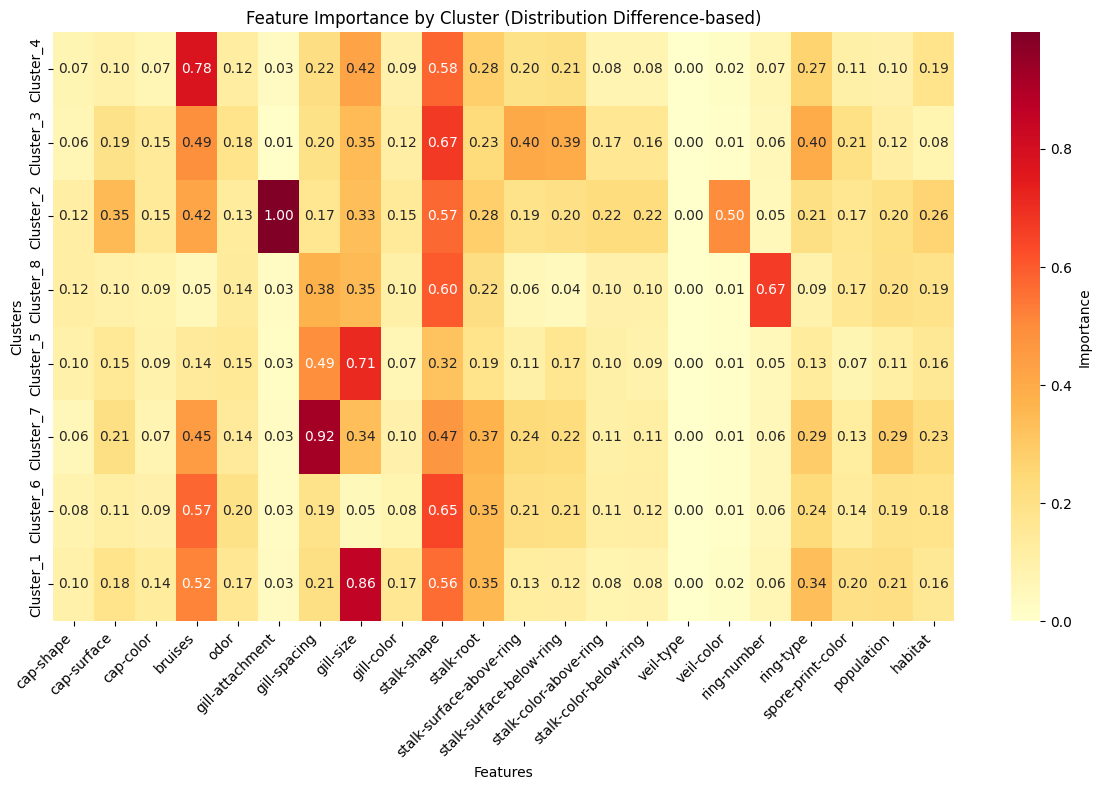

           cap-shape  cap-surface  cap-color   bruises      odor  \
Cluster_4   0.071033     0.098779   0.065545  0.778603  0.121243   
Cluster_3   0.063115     0.191348   0.145322  0.489738  0.183351   
Cluster_2   0.119042     0.349710   0.145206  0.415217  0.132530   
Cluster_8   0.119282     0.098708   0.086231  0.051261  0.139427   
Cluster_5   0.098195     0.153660   0.089844  0.142038  0.154680   
Cluster_7   0.055914     0.208539   0.074208  0.448250  0.143073   
Cluster_6   0.084687     0.110317   0.094395  0.574414  0.197092   
Cluster_1   0.100483     0.183786   0.136333  0.516553  0.165535   

           gill-attachment  gill-spacing  gill-size  gill-color  stalk-shape  \
Cluster_4         0.033188      0.215284   0.424454    0.093538     0.579476   
Cluster_3         0.014174      0.198390   0.346608    0.118016     0.673239   
Cluster_2         0.997612      0.168202   0.331627    0.145798     0.570795   
Cluster_8         0.027279      0.376546   0.348887    0.102853    

'\nFor each cluster, the algorithm computes the normalized value distributions of each feature both within the cluster \nand outside of it. The mean absolute difference between these distributions quantifies how distinctively each feature \ndefines the cluster. The resulting heatmap highlights features with high distribution differences, which are likely \nkey contributors to defining the cluster.\n\nWhen compared to previous analyses of feature means and variances, this approach shifts the focus to the distinctiveness* \nof features. For instance, features like `does-bruise-or-bleed` and `has-ring` show high importance in certain clusters \n(e.g., Cluster 9 and Cluster 8), indicating their strong role in separating these clusters from others. In contrast, \nfeatures with consistently low distribution differences across clusters, such as `stem-height` and `cap-surface`, are less \ncluster-specific and less impactful for differentiation.\n\nThis result contributes to the overall analysi

In [19]:
feature_importance = pd.DataFrame()


for cluster in encoded_data['Cluster'].unique():
    cluster_mask = (encoded_data['Cluster'] == cluster)
    
    cluster_stats = {}
    for column in encoded_data.columns:
        if column not in ['Cluster', 'class']:  
            in_cluster = encoded_data[cluster_mask][column].value_counts(normalize=True)
            out_cluster = encoded_data[~cluster_mask][column].value_counts(normalize=True)
            
            in_cluster, out_cluster = in_cluster.align(out_cluster, fill_value=0)
            
            diff = abs(in_cluster - out_cluster).mean()
            cluster_stats[column] = diff
    
    feature_importance[f'Cluster_{cluster}'] = pd.Series(cluster_stats)

feature_importance = feature_importance.T

plt.figure(figsize=(12, 8))
sns.heatmap(feature_importance, annot=True, cmap='YlOrRd', fmt=".2f", cbar_kws={'label': 'Importance'})
plt.title("Feature Importance by Cluster (Distribution Difference-based)")
plt.xlabel("Features")
plt.ylabel("Clusters")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()
print(feature_importance)

"""
For each cluster, the algorithm computes the normalized value distributions of each feature both within the cluster 
and outside of it. The mean absolute difference between these distributions quantifies how distinctively each feature 
defines the cluster. The resulting heatmap highlights features with high distribution differences, which are likely 
key contributors to defining the cluster.

When compared to previous analyses of feature means and variances, this approach shifts the focus to the distinctiveness* 
of features. For instance, features like `does-bruise-or-bleed` and `has-ring` show high importance in certain clusters 
(e.g., Cluster 9 and Cluster 8), indicating their strong role in separating these clusters from others. In contrast, 
features with consistently low distribution differences across clusters, such as `stem-height` and `cap-surface`, are less 
cluster-specific and less impactful for differentiation.

This result contributes to the overall analysis by pinpointing which features are the most discriminative for clusters. 

"""



Top Features That Separate Clusters:
gill-color                  2.998919
spore-print-color           2.617325
odor                        2.079104
cap-color                   2.011879
ring-type                   2.009997
stalk-color-above-ring      1.561484
stalk-color-below-ring      1.541798
habitat                     1.481549
population                  1.396702
stalk-root                  1.331589
cap-surface                 0.800150
cap-shape                   0.778506
stalk-surface-below-ring    0.586529
stalk-shape                 0.542821
stalk-surface-above-ring    0.530142
bruises                     0.469307
gill-size                   0.468391
gill-spacing                0.417977
veil-color                  0.388444
ring-number                 0.256311
gill-attachment             0.252427
veil-type                   0.000000
dtype: float64


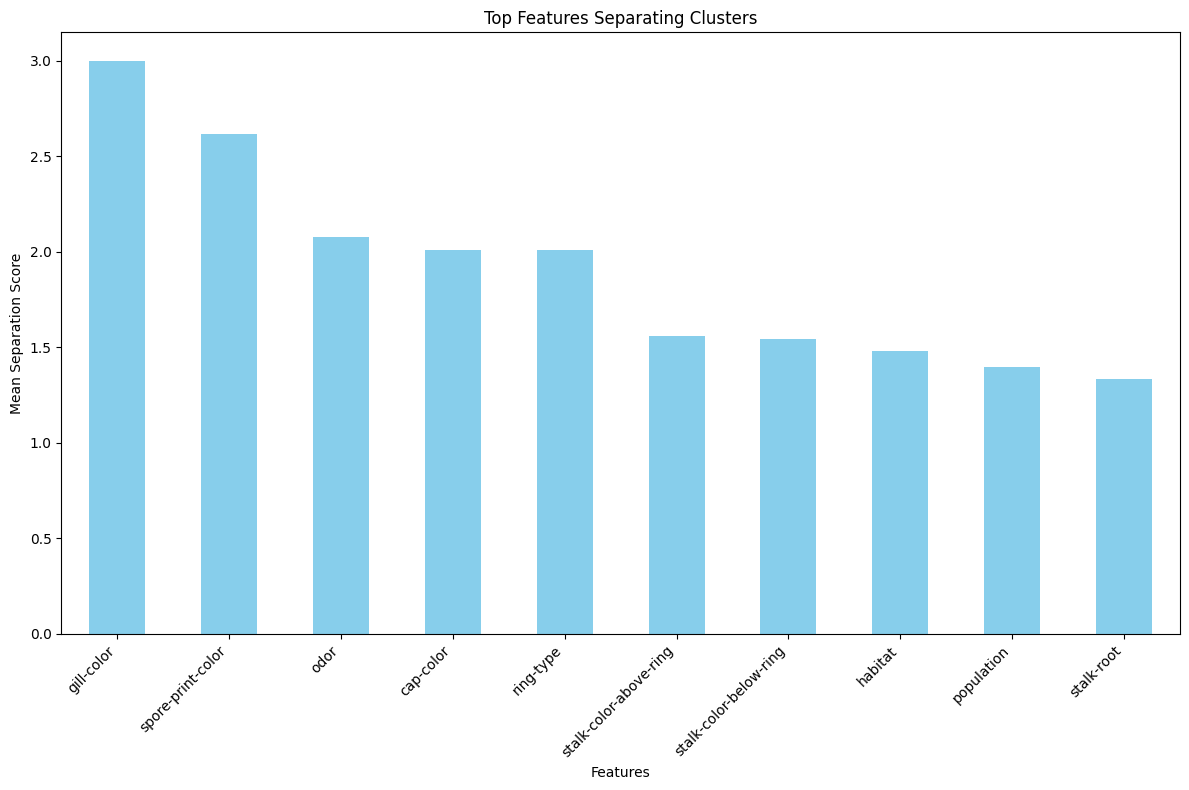

In [20]:
import pandas as pd
import numpy as np
from scipy.stats import wasserstein_distance

separation_scores = pd.DataFrame()

for column in encoded_data.columns:
    if column not in ['Cluster', 'class']:  
        feature_scores = {}
        
        for cluster_1 in encoded_data['Cluster'].unique():
            for cluster_2 in encoded_data['Cluster'].unique():
                if cluster_1 != cluster_2:  
                    cluster_1_values = encoded_data[encoded_data['Cluster'] == cluster_1][column]
                    cluster_2_values = encoded_data[encoded_data['Cluster'] == cluster_2][column]
                    
                    distance = wasserstein_distance(cluster_1_values, cluster_2_values)
                    
                    feature_scores[f"Cluster_{cluster_1}_vs_{cluster_2}"] = distance
        
        separation_scores[column] = pd.Series(feature_scores)

separation_scores = separation_scores.T

sorted_scores = separation_scores.apply(np.mean, axis=1).sort_values(ascending=False)

print("Top Features That Separate Clusters:")
print(sorted_scores)

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
sorted_scores.head(10).plot(kind='bar', color='skyblue')
plt.title("Top Features Separating Clusters")
plt.xlabel("Features")
plt.ylabel("Mean Separation Score")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [10]:
import pandas as pd

n_samples = 3  

cluster_profiles = pd.DataFrame()
sorted_clusters = sorted(encoded_data['Cluster'].unique())

for cluster in sorted_clusters:
    print(f"\nTop {n_samples} Representative Samples from Cluster {cluster}:")
    print("-" * 50)
    
    cluster_data = encoded_data[encoded_data['Cluster'] == cluster]
    
    cluster_features = cluster_data.drop(columns=['Cluster', 'class'])
    cluster_centroid = cluster_features.mean(axis=0)  
    distances = pairwise_distances(cluster_features, [cluster_centroid], metric='euclidean').flatten()
    
    cluster_data['Distance_to_Centroid'] = distances
    top_samples = cluster_data.nsmallest(n=n_samples, columns='Distance_to_Centroid')
    
    print(top_samples.drop(columns=['Cluster', 'Distance_to_Centroid']))
    
    profile = {}
    for column in encoded_data.columns:
        if column not in ['Cluster', 'class']:
            value_counts = cluster_data[column].value_counts(normalize=True)
            if not value_counts.empty:
                most_common = value_counts.index[0]
                percentage = value_counts.iloc[0] * 100
                profile[column] = f"{most_common} ({percentage:.1f}%)"
            else:
                profile[column] = "No Data"
    
    cluster_profiles[f"Cluster {cluster}"] = pd.Series(profile)

cluster_profiles = cluster_profiles.reindex(sorted(cluster_profiles.columns), axis=1)

print("\nCluster Defining Features:")
print(cluster_profiles)







Top 3 Representative Samples from Cluster 1:
--------------------------------------------------
      class  cap-shape  cap-surface  cap-color  bruises  odor  \
2450      1          3            3          4        0     7   
2635      1          3            3          4        0     7   
1963      1          3            2          4        0     7   

      gill-attachment  gill-spacing  gill-size  gill-color  ...  \
2450                1             0          1           0  ...   
2635                1             0          1           0  ...   
1963                1             0          1           0  ...   

      stalk-surface-below-ring  stalk-color-above-ring  \
2450                         2                       6   
2635                         2                       7   
1963                         2                       6   

      stalk-color-below-ring  veil-type  veil-color  ring-number  ring-type  \
2450                       6          0           2          

/var/folders/k8/kp1njk3j6ms3bxl4lxwr6xth0000gn/T/ipykernel_30920/3562122046.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_data['Distance_to_Centroid'] = distances
/var/folders/k8/kp1njk3j6ms3bxl4lxwr6xth0000gn/T/ipykernel_30920/3562122046.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_data['Distance_to_Centroid'] = distances
/var/folders/k8/kp1njk3j6ms3bxl4lxwr6xth0000gn/T/ipykernel_30920/3562122046.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

In [11]:
def analyze_mushroom_clusters(encoded_data, cluster_labels, label_encoders):
    """
    Comprehensive analysis of mushroom clustering results
    """
    analysis_results = {}
    
    cluster_sizes = pd.Series(cluster_labels).value_counts().sort_index()
    analysis_results['cluster_sizes'] = cluster_sizes
    
    cluster_features = encoded_data.copy()
    cluster_features['Cluster'] = cluster_labels
    
    feature_importance = {}
    for cluster in cluster_sizes.index:
        cluster_data = cluster_features[cluster_features['Cluster'] == cluster]
        overall_mean = encoded_data.mean()
        cluster_mean = cluster_data.mean()
        
        deviation = (cluster_mean - overall_mean).abs()
        top_features = deviation.nlargest(3)
        
        decoded_features = {}
        for feature, value in top_features.items():
            if feature in label_encoders:
                encoded_value = int(cluster_mean[feature])
                decoded_value = label_encoders[feature].inverse_transform([encoded_value])[0]
                decoded_features[feature] = decoded_value
                
        feature_importance[f'Cluster_{cluster}'] = decoded_features
    
    analysis_results['feature_importance'] = feature_importance
    
    cluster_class = pd.DataFrame({
        'Cluster': cluster_labels,
        'Class': encoded_data['class']
    })
    
    purity_analysis = cluster_class.groupby('Cluster').agg({
        'Class': lambda x: x.value_counts(normalize=True).to_dict()
    })
    
    analysis_results['cluster_purity'] = purity_analysis
    
    return analysis_results

results = analyze_mushroom_clusters(encoded_data, cluster_labels, label_encoders)

print("\nCluster Sizes:")
print(results['cluster_sizes'])

print("\nMost Distinctive Features per Cluster:")
for cluster, features in results['feature_importance'].items():
    print(f"\n{cluster}:")
    for feature, value in features.items():
        print(f"  {feature}: {value}")

print("\nCluster Purity (Class Distribution):")
print(results['cluster_purity'])


Cluster Sizes:
1    644
2     69
3    515
4    710
5    155
6    408
7    285
8    214
Name: count, dtype: int64

Most Distinctive Features per Cluster:

Cluster_1:
  gill-color: b
  spore-print-color: w

Cluster_2:
  gill-color: p
  ring-type: p

Cluster_3:
  stalk-color-above-ring: g
  spore-print-color: h
  stalk-color-below-ring: g

Cluster_4:
  gill-color: p
  ring-type: p
  cap-color: g

Cluster_5:
  gill-color: o
  odor: c
  cap-color: r

Cluster_6:
  cap-color: r
  ring-type: p

Cluster_7:
  ring-type: e
  population: c

Cluster_8:
  spore-print-color: u
  gill-color: o

Cluster Purity (Class Distribution):
                                                    Class
Cluster                                                  
1                                                {1: 1.0}
2                                                {0: 1.0}
3        {1: 0.9631067961165048, 0: 0.036893203883495145}
4         {0: 0.8338028169014085, 1: 0.16619718309859155}
5          {1: 0.65806451612

Data Statistics:
Number of samples: 3000
Number of features: 22
Data range: [-7.99, 4.20]

Linkage Matrix Statistics:
Distance range in linkage matrix: [0.28, 140.73]

Suggested threshold range based on linkage matrix: [0.39, 3.74]
Threshold 5.00: 209 clusters
Threshold 10.00: 83 clusters
Threshold 15.00: 51 clusters
Threshold 20.00: 34 clusters
Threshold 25.00: 25 clusters
Threshold 30.00: 20 clusters
Threshold 35.00: 16 clusters
Threshold 40.00: 14 clusters
Threshold 45.00: 11 clusters
Threshold 50.00: 8 clusters
Threshold 55.00: 8 clusters
Threshold 60.00: 7 clusters
Threshold 65.00: 7 clusters
Threshold 70.00: 7 clusters
Threshold 75.00: 7 clusters
Threshold 80.00: 7 clusters
Threshold 85.00: 7 clusters
Threshold 90.00: 6 clusters
Threshold 95.00: 6 clusters
Threshold 100.00: 5 clusters


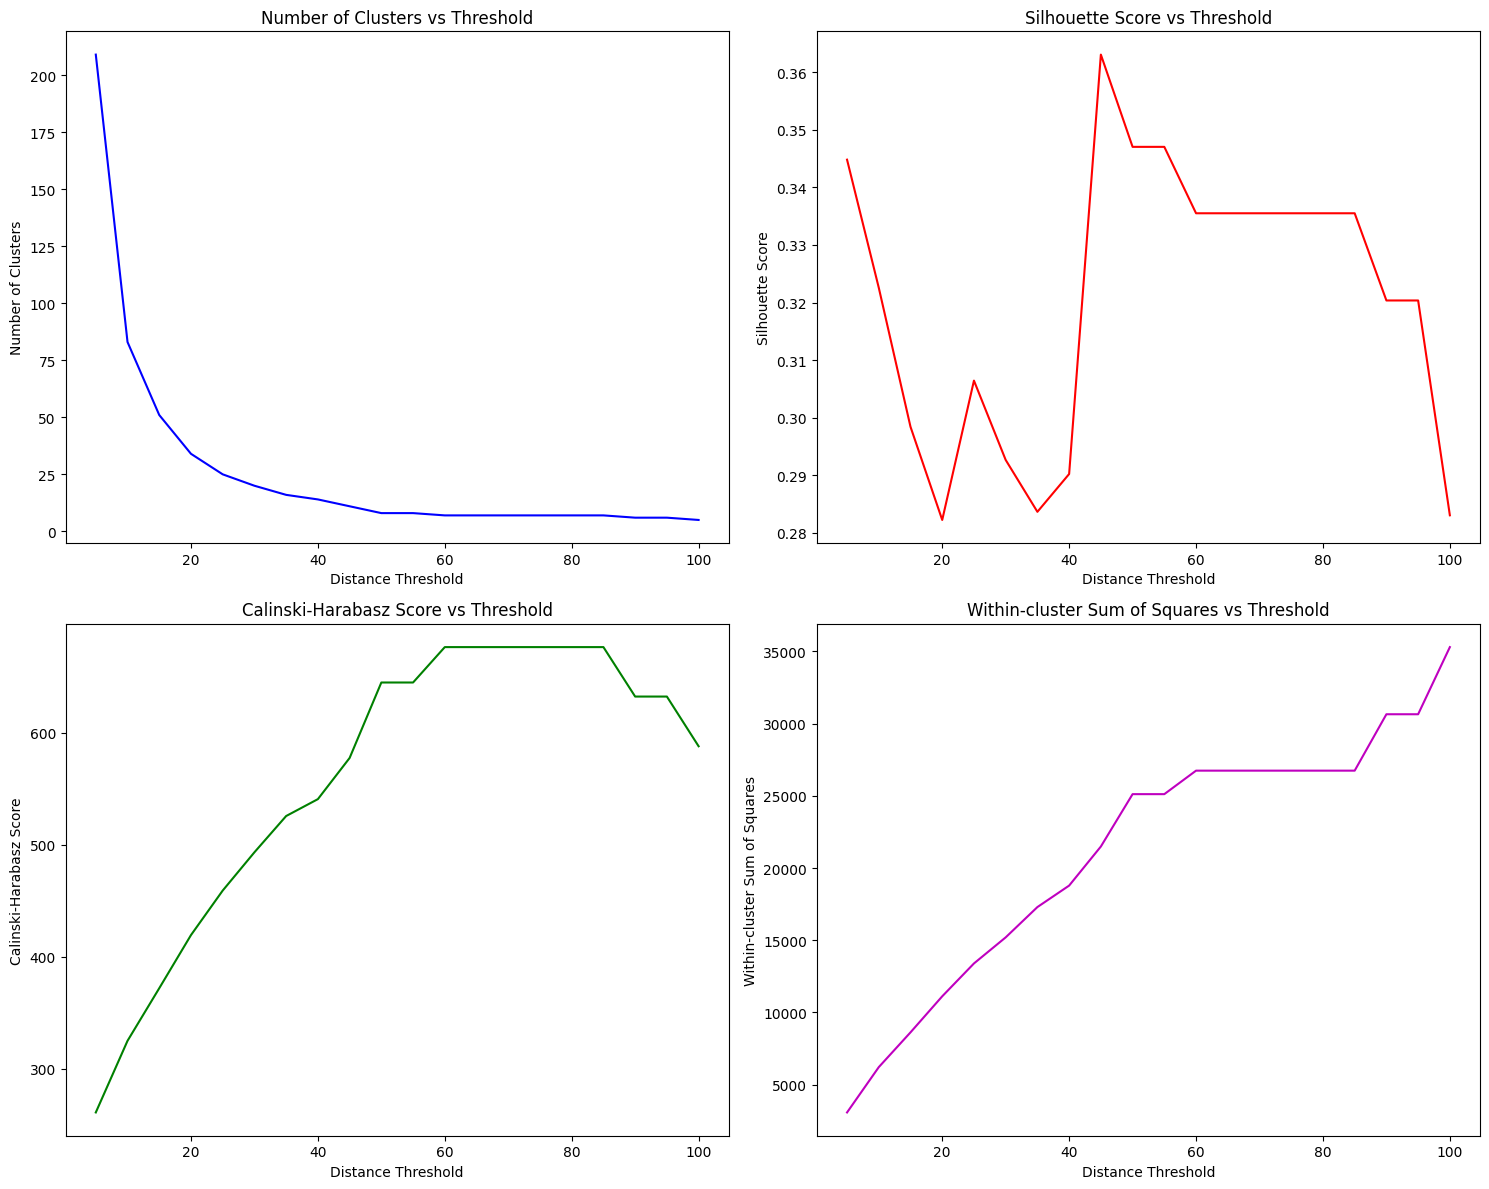


Best configuration based on Silhouette score:
Threshold: 45.00
Number of clusters: 11
Silhouette score: 0.363


In [12]:
import numpy as np
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from scipy.cluster.hierarchy import fcluster
import matplotlib.pyplot as plt

def analyze_optimal_clusters_revised(linkage_matrix, X_scaled, min_threshold=5, max_threshold=200, num_points=20):
    """
    Analyze optimal number of clusters with revised threshold range and additional diagnostics
    """
    print("Data Statistics:")
    print(f"Number of samples: {X_scaled.shape[0]}")
    print(f"Number of features: {X_scaled.shape[1]}")
    print(f"Data range: [{X_scaled.min():.2f}, {X_scaled.max():.2f}]")
    print("\nLinkage Matrix Statistics:")
    print(f"Distance range in linkage matrix: [{linkage_matrix[:, 2].min():.2f}, {linkage_matrix[:, 2].max():.2f}]")
    
    distances = linkage_matrix[:, 2]
    suggested_min = np.percentile(distances, 10)
    suggested_max = np.percentile(distances, 90)
    print(f"\nSuggested threshold range based on linkage matrix: [{suggested_min:.2f}, {suggested_max:.2f}]")
    
    thresholds = np.linspace(min_threshold, max_threshold, num_points)
    
    n_clusters = []
    silhouette_scores = []
    calinski_scores = []
    within_cluster_ss = []
    
    # Calculate metrics for different thresholds
    for threshold in thresholds:
        labels = fcluster(linkage_matrix, t=threshold, criterion='distance')
        n_clust = len(np.unique(labels))
        n_clusters.append(n_clust)
        
        print(f"Threshold {threshold:.2f}: {n_clust} clusters")
        
        if n_clust == 1 or n_clust >= X_scaled.shape[0] - 1:
            silhouette_scores.append(0)
            calinski_scores.append(0)
            within_cluster_ss.append(0)
            continue
            
        silhouette_scores.append(silhouette_score(X_scaled, labels))
        calinski_scores.append(calinski_harabasz_score(X_scaled, labels))
        
        wcss = 0
        for i in range(1, n_clust + 1):
            cluster_points = X_scaled[labels == i]
            centroid = cluster_points.mean(axis=0)
            wcss += np.sum((cluster_points - centroid) ** 2)
        within_cluster_ss.append(wcss)

    # Plot results
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
    
    # Plot 1: Number of clusters vs threshold
    ax1.plot(thresholds, n_clusters, 'b-')
    ax1.set_xlabel('Distance Threshold')
    ax1.set_ylabel('Number of Clusters')
    ax1.set_title('Number of Clusters vs Threshold')
    
    # Plot 2: Silhouette score
    valid_idx = np.where(np.array(n_clusters) > 1)[0]
    if len(valid_idx) > 0:
        ax2.plot(thresholds[valid_idx], np.array(silhouette_scores)[valid_idx], 'r-')
        ax2.set_xlabel('Distance Threshold')
        ax2.set_ylabel('Silhouette Score')
        ax2.set_title('Silhouette Score vs Threshold')
    
    # Plot 3: Calinski-Harabasz score
    if len(valid_idx) > 0:
        ax3.plot(thresholds[valid_idx], np.array(calinski_scores)[valid_idx], 'g-')
        ax3.set_xlabel('Distance Threshold')
        ax3.set_ylabel('Calinski-Harabasz Score')
        ax3.set_title('Calinski-Harabasz Score vs Threshold')
    
    # Plot 4: Within-cluster sum of squares
    if len(valid_idx) > 0:
        ax4.plot(thresholds[valid_idx], np.array(within_cluster_ss)[valid_idx], 'm-')
        ax4.set_xlabel('Distance Threshold')
        ax4.set_ylabel('Within-cluster Sum of Squares')
        ax4.set_title('Within-cluster Sum of Squares vs Threshold')
    
    plt.tight_layout()
    plt.show()
    
    return {
        'thresholds': thresholds,
        'n_clusters': n_clusters,
        'silhouette_scores': silhouette_scores,
        'calinski_scores': calinski_scores,
        'within_cluster_ss': within_cluster_ss
    }

results = analyze_optimal_clusters_revised(linkage_matrix, X_scaled, min_threshold=5, max_threshold=100)

valid_idx = np.where(np.array(results['n_clusters']) > 1)[0]
if len(valid_idx) > 0:
    best_idx = valid_idx[np.argmax(np.array(results['silhouette_scores'])[valid_idx])]
    best_threshold = results['thresholds'][best_idx]
    best_n_clusters = results['n_clusters'][best_idx]
    print(f"\nBest configuration based on Silhouette score:")
    print(f"Threshold: {best_threshold:.2f}")
    print(f"Number of clusters: {best_n_clusters}")
    print(f"Silhouette score: {results['silhouette_scores'][best_idx]:.3f}")